# XGBOOST REGRESSOR

In [1]:
import sys, os
sys.path.append(r"C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction")
import utils
from IPython.display import HTML, display
display(HTML("<style>.output_scroll {height:auto !important; max-height:none !important;}</style>"))

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
x_train, y_train, x_test, y_test = utils.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

print("Before:", y_train.shape)
print("Before:", y_test.shape)
#Random Forest Regressor expects 1D target array so we can ravel y
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print("After:", y_train.shape)
print("After: ", y_test.shape)

(3160, 18) (3160, 1) (791, 18) (791, 1)
Before: (3160, 1)
Before: (791, 1)
After: (3160,)
After:  (791,)


## XGBRegressor BASELINE MODEL

In [4]:
x_train_all =x_train.copy()
x_test_all = x_test.copy()

x_train = x_train.drop(columns=["date"],errors = "ignore")
x_test = x_test.drop(columns=["date"], errors= "ignore")

In [5]:
xgb_baseline = XGBRegressor(objective='reg:squarederror',n_estimators = 200,
                            learning_rate = 0.1,
                            max_dept = 6, subsample = 0.8, colsample_bytree=0.8,
                            eval_metric='rmse',
                            early_stopping_rounds=15,
                            random_state = 42,
                            n_jobs=-1)
xgb_baseline.fit(x_train, y_train,
          eval_set=[(x_test, y_test)],
          verbose=True)   

[0]	validation_0-rmse:1.06921
[1]	validation_0-rmse:0.98787
[2]	validation_0-rmse:0.91725
[3]	validation_0-rmse:0.85342
[4]	validation_0-rmse:0.80053
[5]	validation_0-rmse:0.75509
[6]	validation_0-rmse:0.71668
[7]	validation_0-rmse:0.67938
[8]	validation_0-rmse:0.64836
[9]	validation_0-rmse:0.62014
[10]	validation_0-rmse:0.59810
[11]	validation_0-rmse:0.57805
[12]	validation_0-rmse:0.55965
[13]	validation_0-rmse:0.54331
[14]	validation_0-rmse:0.52820
[15]	validation_0-rmse:0.51868
[16]	validation_0-rmse:0.50999
[17]	validation_0-rmse:0.50259
[18]	validation_0-rmse:0.49628
[19]	validation_0-rmse:0.49090
[20]	validation_0-rmse:0.48655
[21]	validation_0-rmse:0.48257
[22]	validation_0-rmse:0.47914
[23]	validation_0-rmse:0.47729
[24]	validation_0-rmse:0.47454
[25]	validation_0-rmse:0.47279
[26]	validation_0-rmse:0.46951
[27]	validation_0-rmse:0.46670
[28]	validation_0-rmse:0.46504
[29]	validation_0-rmse:0.46252
[30]	validation_0-rmse:0.46126
[31]	validation_0-rmse:0.46010
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=15,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_dept=6,
             max_depth=None, max_leaves=None, min_child_weight=None,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=200, n_jobs=-1, ...)

RMSE started from 1.07 and gradually reduced to 0.45 in the final iteration. THis is the model's prediction error on the validation set (test) 

### SAVE MODEL

In [6]:
utils.save_model(xgb_baseline, "xgbRegressorBaseline")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\xgbRegressorBaseline.pkl


### EVALUATE MODEL

[INOF] Starting evaluation for model: xgbRegressorBaseline
[SUCCESS] Metrics calculated for xgbRegressorBaseline


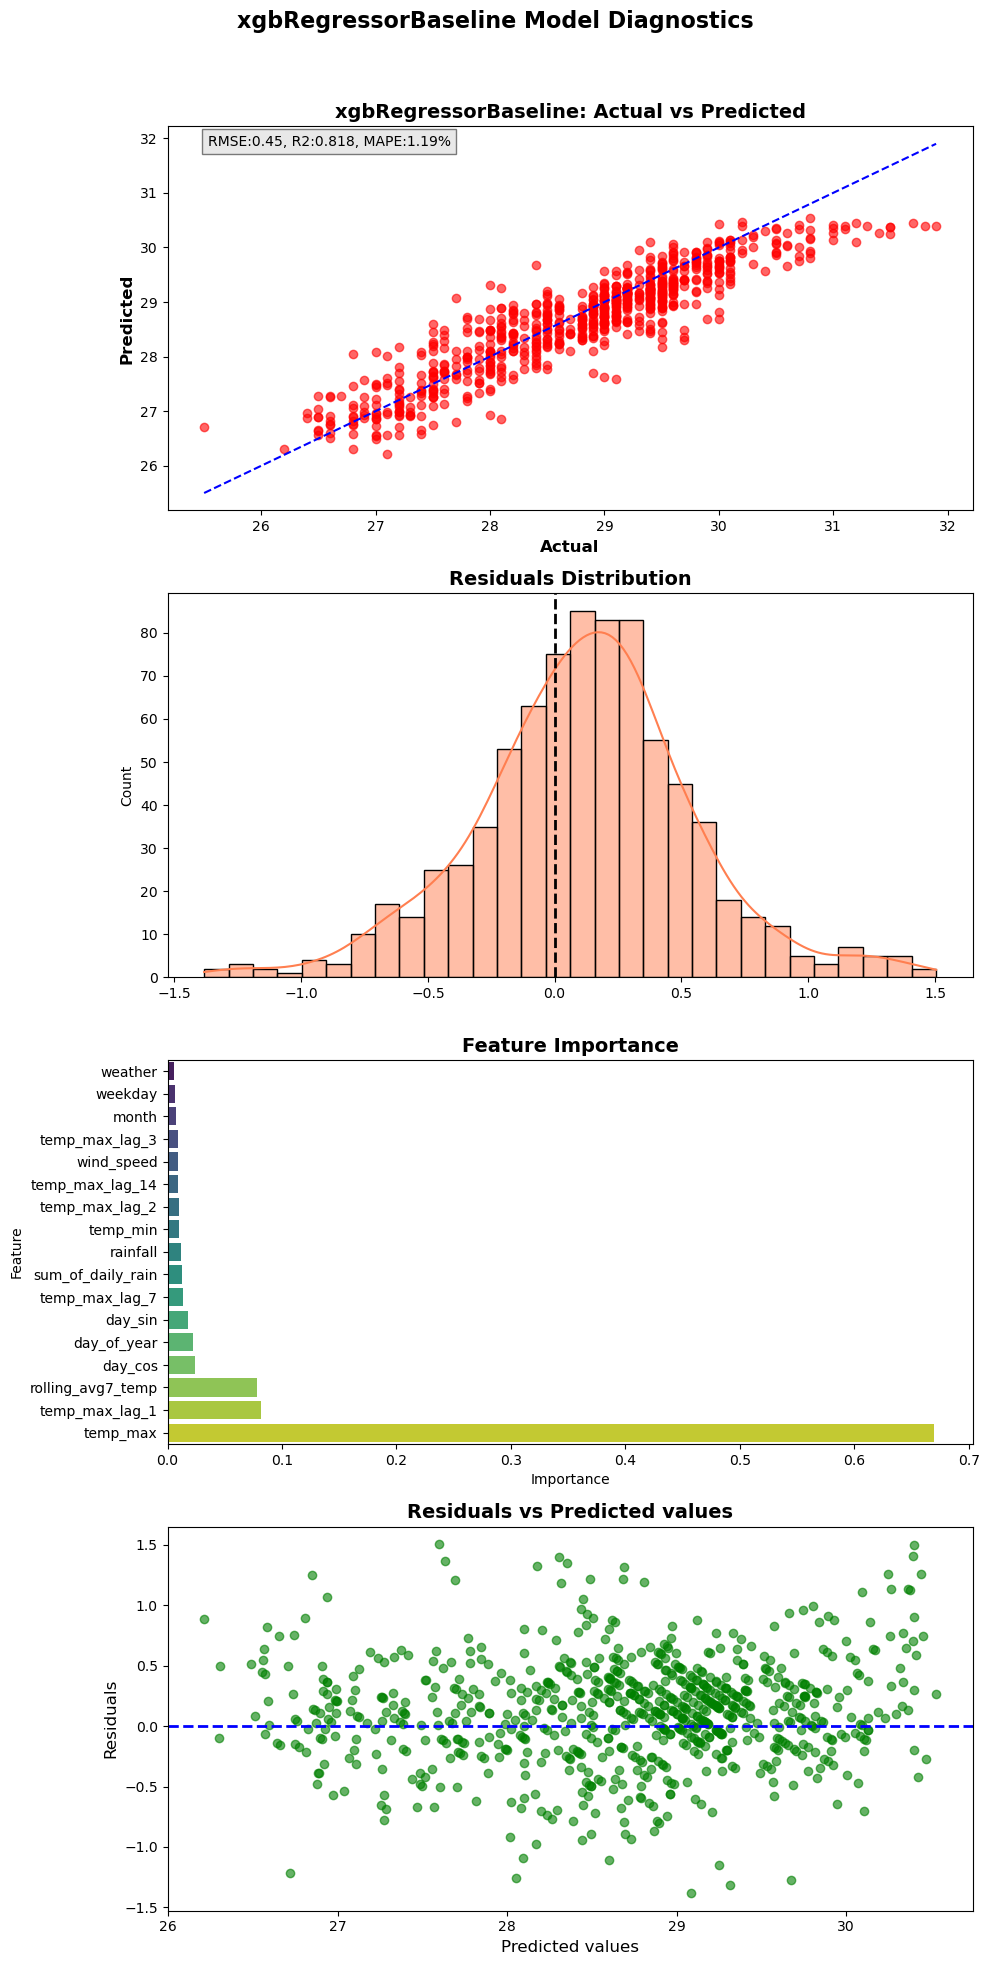

[SUCCESS] Visualization completed for xgbRegressorBaseline


{'model': 'xgbRegressorBaseline',
 'rmse': 0.448226160143774,
 'r2': 0.818123152772134,
 'mape': 1.1931035322662316}

In [7]:
utils.evaluate_model(x_test, y_test, "xgbRegressorBaseline")

## SHAP ALTERNATIVE FOR MODEL EXPLAINABILITY

### PERMUTATION IMPORTANCE

shuffling each feature's values randomly while keeping others fixed
seeing how much prediction error increases.
the bigger the increase, the more important that feature is
Bar chart

### PARTIAL DEPENDENCE PLOTS

shows how predicted temperature changes when one feature varies while keeping other constant.
perfect for interpreting continuous features in regression like weather metrics
to understand feature influence

### LIME

shap.Explainer(xgb_baseline, algorithm='tree') instead of TreeExplainer

### PERMUTAION IMPORTANCE
Measures how much each feature contributes to the model's predictive performance, by seeing how bad the model performs when that feature's information is removed.

taking one feature say rainfall and shuffle its values randomly in the test set. this breaks the true relationship between rainfall and the target temp_max. Rerunning the predictions on this shuffled data.

RMSE - if performance drops a lot this is important to note
R2score - if performance hardly changes - not importance
Use test set only. 

In [11]:
from sklearn.inspection import permutation_importance
"""
sklearn.inspection.permutation_importance(estimator, X, y, *, scoring=None, 
n_repeats=5, n_jobs=None, random_state=None, sample_weight=None, max_samples=1.0)
"""

In [17]:
print("[INFO] calculating permutation importance for xgb_baseline")
result = permutation_importance(xgb_baseline, x_test, y_test, 
                                n_repeats = 10, random_state=42, n_jobs=-1)
result.keys()

[INFO] calculating permutation importance for xgb_baseline


dict_keys(['importances_mean', 'importances_std', 'importances'])

In [19]:
perm_importance_df = pd.DataFrame({"Feature":x_test.columns,
                                   "Importance_Mean": result.importances_mean,
                                   "Importancs_Std": result.importances_std}).sort_values(by="Importance_Mean",ascending=False)
perm_importance_df

,Feature,Importance_Mean,Importancs_Std
1,temp_max,0.684463,0.026506
16,rolling_avg7_temp,0.026751,0.002968
6,day_of_year,0.019067,0.002250
5,wind_speed,0.012256,0.002157
11,temp_max_lag_1,0.011917,0.001552
14,temp_max_lag_7,0.010461,0.001999
3,rainfall,0.008344,0.001856
9,day_sin,0.008266,0.001462
10,day_cos,0.008136,0.001381
13,temp_max_lag_3,0.005349,0.001916


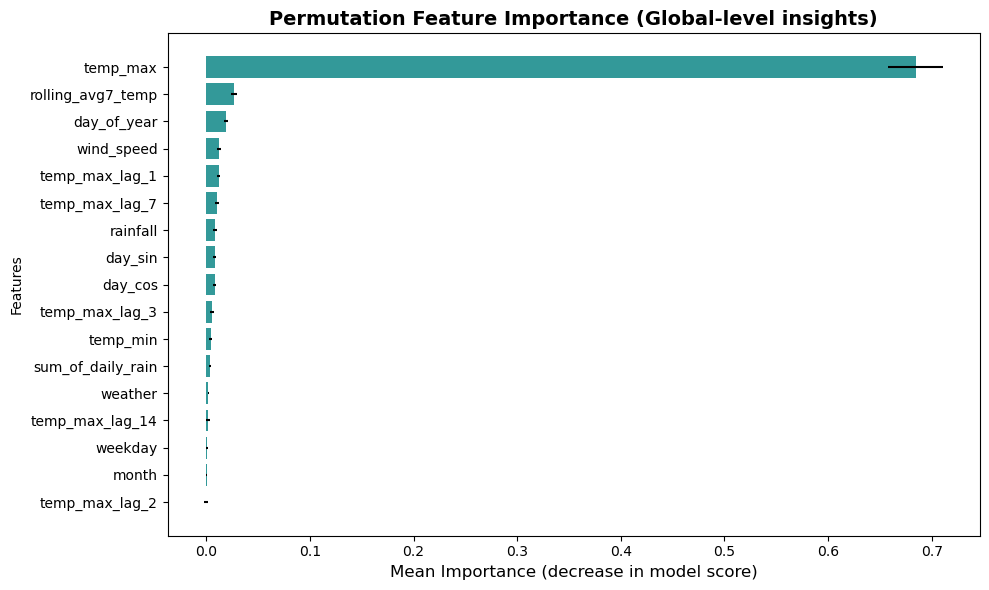

"\nwe can see the key drivers here'\n"

In [32]:
plt.figure(figsize=(10,6))
plt.barh(perm_importance_df["Feature"], perm_importance_df["Importance_Mean"],
         xerr = perm_importance_df["Importancs_Std"], alpha=0.8, color="teal")
plt.gca().invert_yaxis()#order it
plt.title("Permutation Feature Importance (Global-level insights)",fontsize=14, weight="bold")
plt.xlabel("Mean Importance (decrease in model score)", fontsize=12)
plt.ylabel("Features")
plt.tight_layout()
plt.show()
"""
we can see the key drivers here'
"""

In [35]:
list(perm_importance_df['Feature'][0:3])

['temp_max', 'rolling_avg7_temp', 'day_of_year']

### PARTIAL DEPENDENCE PLOT
If we vary one feature while keeping all others constanst, how does the model's prediction change on average?
Permutation importance said which features matter
PDP will tell how these features influence predictions

In [24]:
from sklearn.inspection import PartialDependenceDisplay

[INFO] Generating Partial Dependence Plot for XGBoost Model


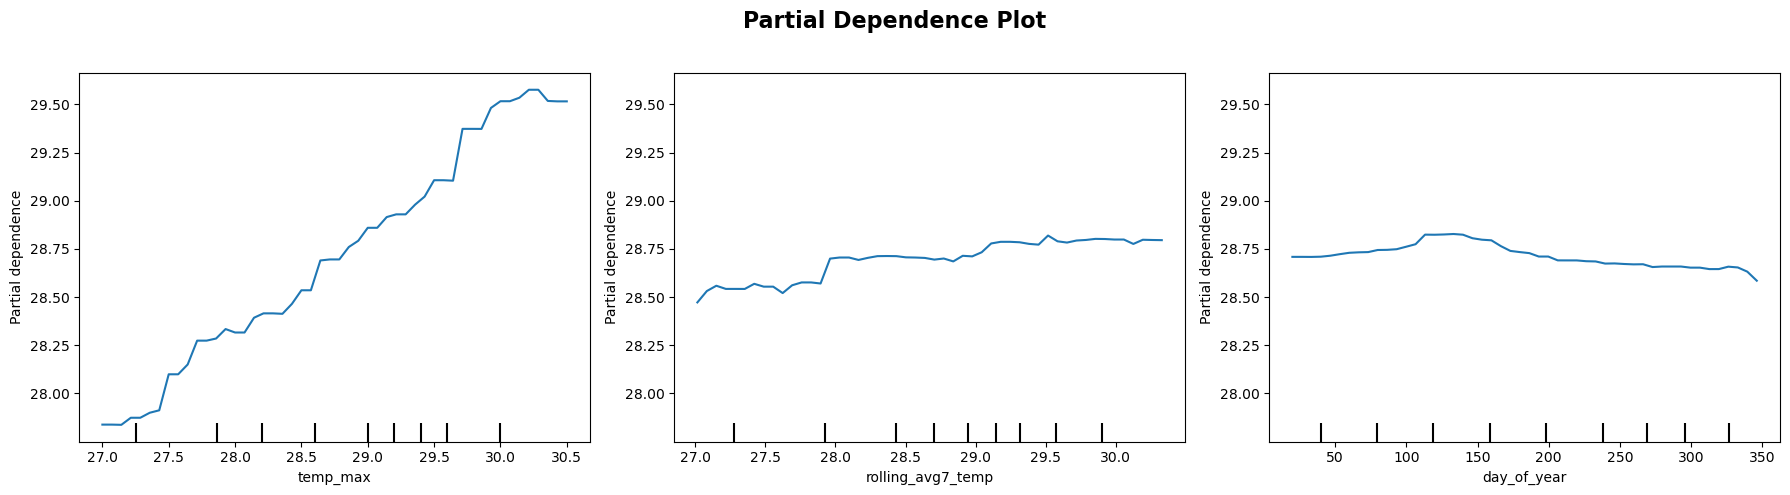

[INFO] Generating 2D Interaction Plot b/w temp_max X day_of_year


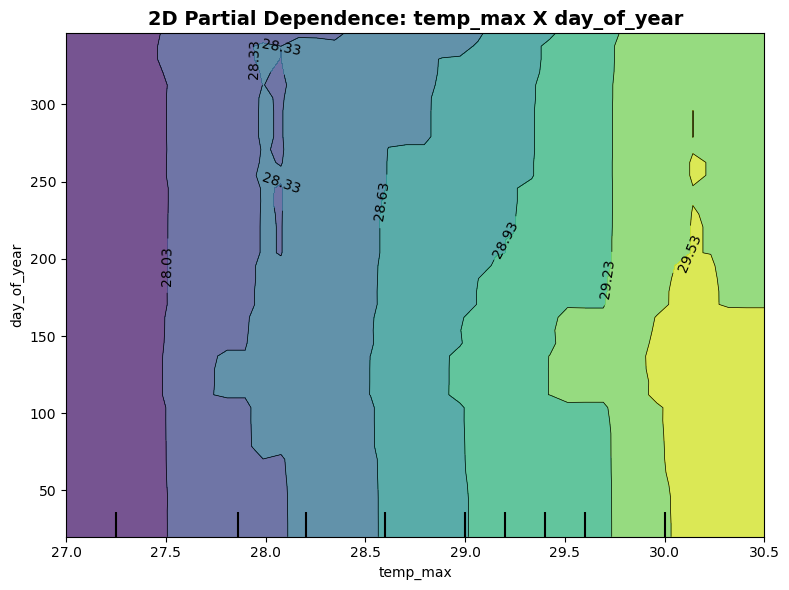

In [39]:
top_features = list(perm_importance_df['Feature'][0:3])
print("[INFO] Generating Partial Dependence Plot for XGBoost Model")

fig, ax = plt.subplots(ncols=len(top_features), figsize=(18,5))
PartialDependenceDisplay.from_estimator(xgb_baseline, X=x_test, features=top_features,
                                         ax=ax,
                                         kind='average',
                                         grid_resolution = 50)
plt.suptitle("Partial Dependence Plot", fontsize=16, weight="bold")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

interaction_features = [("temp_max", "day_of_year")]
print("[INFO] Generating 2D Interaction Plot b/w temp_max X day_of_year")
fig, ax = plt.subplots(figsize = (8,6))
PartialDependenceDisplay.from_estimator(xgb_baseline, X=x_test, features = interaction_features,
                                        ax=ax,
                                        kind='average',
                                        grid_resolution=40)
plt.title("2D Partial Dependence: temp_max X day_of_year", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

purple - blue - green - yellow
aveg predicted temperature by our model.
Purple/dark blue - lower predicted temperature - cooler
light green/yellow - higher predicted temperature - hotter
27- 28 deg c - even as day_of_year changes, pred temp remains low
28.5-29 deg C - gradual warming trend
 >29.5 deg c - strong positive influence - summer zone

Variation across day_of_year- the mild vertical undulations that is the contour shifts suggests that seasonality still matter.
THe same temp_max can yield different forecasts depending on which part of the year it occurs. This happens because our other features humidity, rainfall, lag features interact with seasonality.


## HYPERPARAMETER TUNING 
## RANDOMIZED SEARCH CV

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score
import time

In [7]:
xgb_model = XGBRegressor(objective='reg:squarederror',
                         random_state =42,
                         n_jobs=-1,
                         eval_metric="rmse")
param_dist = {"n_estimators":randint(100,700),
              "learning_rate":uniform(0.01, 0.3),
              "max_dept":randint(3,9),
              "min_child_weight":randint(1,10),
              "gamma":uniform(0,0.5),
              "subsample":uniform(0.6,0.4),
              "colsample_bytree":uniform(0.6,0.4),
              "reg_lambda":uniform(0,5),
              "reg_alpha":uniform(0,5)}
random_search = RandomizedSearchCV(estimator = xgb_model,
                                   param_distributions = param_dist,
                                   n_iter = 30,
                                   scoring='neg_root_mean_squared_error',
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1, return_train_score=True)
# FIT the search
start_time = time.time()
random_search.fit(x_train, y_train)
"""x_train tree  based lke random forest scaling is not required.
np.ravel(y_train) reshapes our 2d array to 1d vector. that is a must for fit compatibility.
"""
end_time = time.time()
elapsed_time = end_time - start_time
print(f"RandomizedSearchCV completed in {elapsed_time/60:.2f} minutes")
print("Best params found:")
for k,v in random_search.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomizedSearchCV completed in 0.62 minutes
Best params found:
  colsample_bytree: 0.8493192507310232
  gamma: 0.1654490124263246
  learning_rate: 0.02906750508580709
  max_dept: 8
  min_child_weight: 8
  n_estimators: 198
  reg_alpha: 2.9564889385386355
  reg_lambda: 1.373608964950321
  subsample: 0.8244973703390804


In [13]:
best_xgb = random_search.best_estimator_
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8493192507310232, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=0.1654490124263246, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02906750508580709,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_dept=8, max_depth=None, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=198, n_jobs=-1, ...)

In [49]:
utils.save_model(best_xgb, "random_search_cv_xgbRegressor")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\random_search_cv_xgbRegressor.pkl


[INOF] Starting evaluation for model: random_search_cv_xgbRegressor
[SUCCESS] Metrics calculated for random_search_cv_xgbRegressor


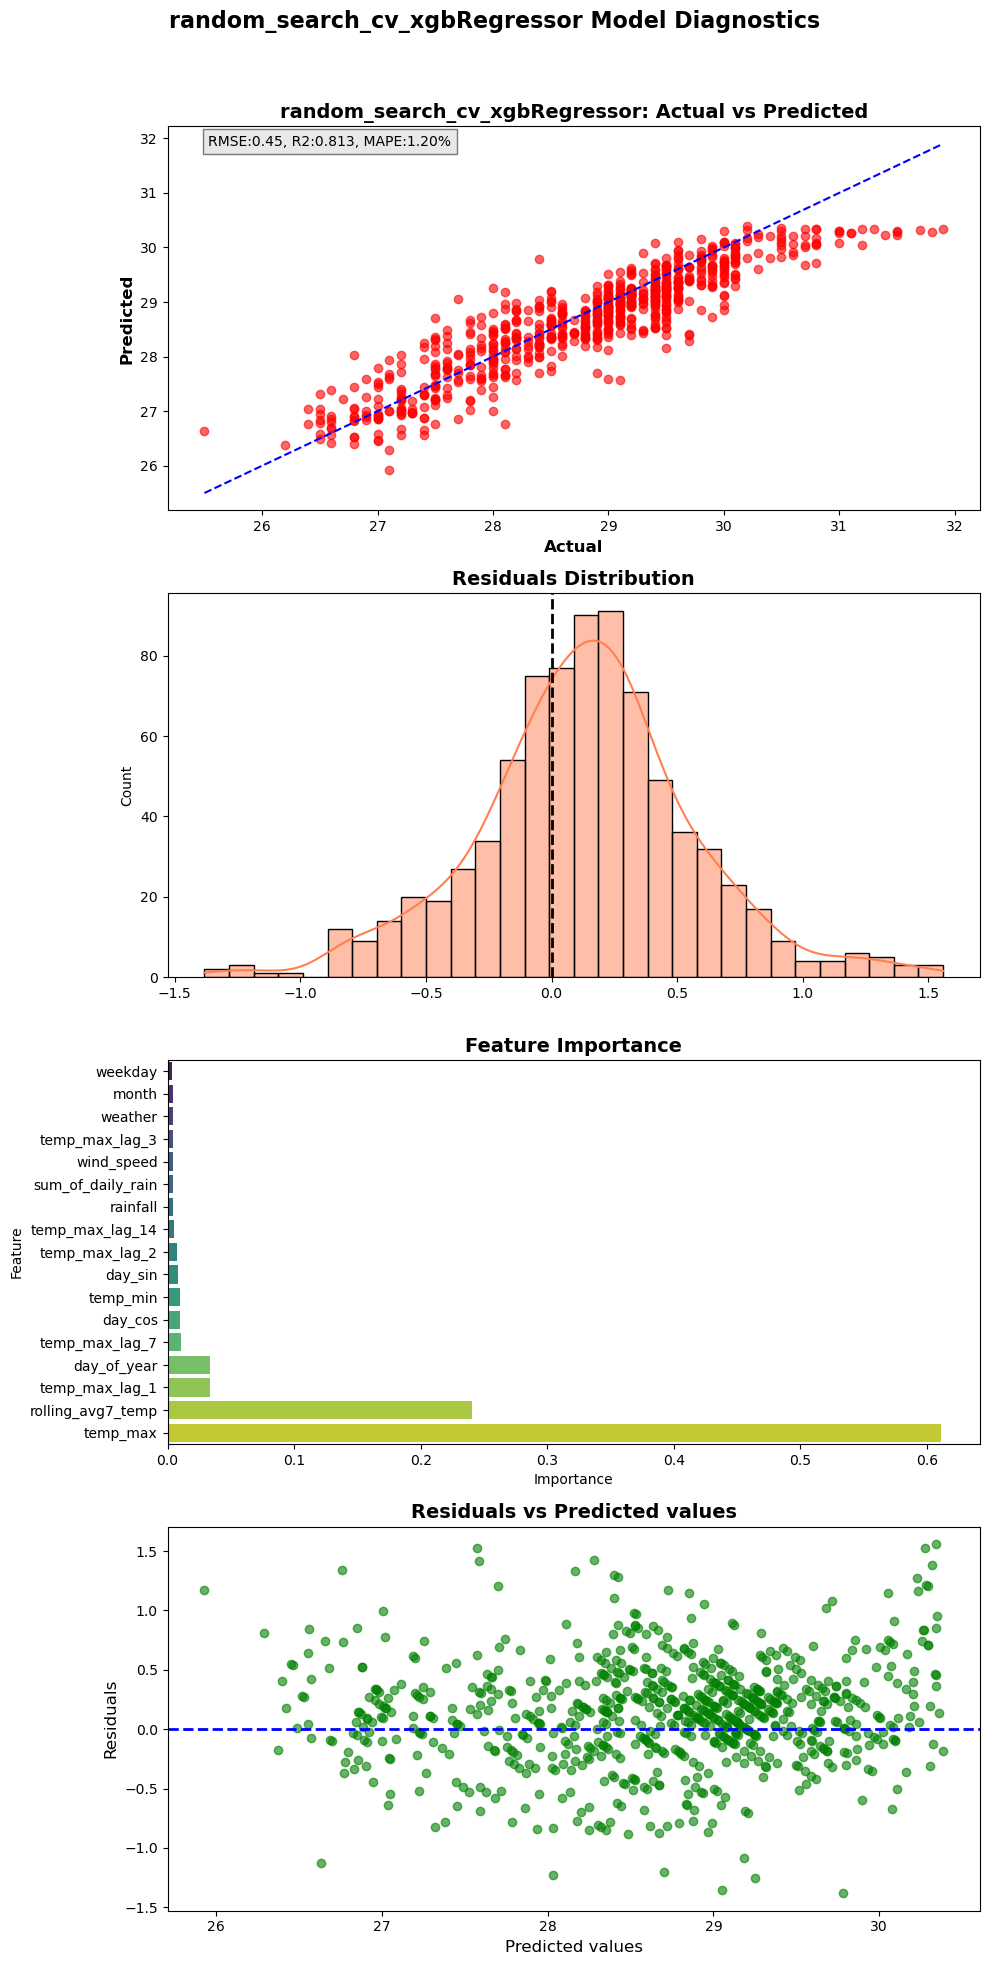

[SUCCESS] Visualization completed for random_search_cv_xgbRegressor
Model: random_search_cv_xgbRegressor, RMSE: 0.455, R²: 0.813, MAPE: 1.20%


In [14]:
results = utils.evaluate_model(x_test, y_test, name="random_search_cv_xgbRegressor")
print(f"Model: {results['model']}, RMSE: {results['rmse']:.3f}, R²: {results['r2']:.3f}, MAPE: {results['mape']:.2f}%")

In [15]:
for k,v in random_search.best_params_.items():
    print(f"  {k}: {v}")

  colsample_bytree: 0.8493192507310232
  gamma: 0.1654490124263246
  learning_rate: 0.02906750508580709
  max_dept: 8
  min_child_weight: 8
  n_estimators: 198
  reg_alpha: 2.9564889385386355
  reg_lambda: 1.373608964950321
  subsample: 0.8244973703390804


## GRID SEARCH CV

In [9]:
from sklearn.model_selection import GridSearchCV

## HALVING GRID SEARCH CV

In [10]:
#enable experimental api
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [16]:
#taking a deep copy of best_xgb to avoid the chances of overwritting the random search version
import copy
xgb_base = copy.deepcopy(best_xgb)

In [17]:
param_grid = {
    'learning_rate': [0.025, 0.03, 0.035],
    'max_depth': [7, 8, 9],
    'min_child_weight': [6, 8, 10],
    'colsample_bytree': [0.8, 0.85, 0.9],
    'subsample': [0.8, 0.85, 0.9],
    'gamma': [0.1, 0.15, 0.2],
    'reg_alpha': [2.5, 3.0, 3.5],
    'reg_lambda': [1.0, 1.3, 1.6]
}
halving_grid = HalvingGridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    factor=3,
    resource='n_estimators',
    max_resources=250,#Max estimators.
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)
print("\n[INFO] Starting HalvingGridSearchCV fine-tuning for XGBoost...")
start_time = time.time()

halving_grid.fit(x_train, y_train)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(f"[INFO] HalvingGridSearchCV completed in {elapsed_time:.2f} minutes")


[INFO] Starting HalvingGridSearchCV fine-tuning for XGBoost...
n_iterations: 6
n_required_iterations: 9
n_possible_iterations: 6
min_resources_: 1
max_resources_: 250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6561
n_resources: 1
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
----------
iter: 1
n_candidates: 2187
n_resources: 3
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
----------
iter: 2
n_candidates: 729
n_resources: 9
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
----------
iter: 3
n_candidates: 243
n_resources: 27
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
----------
iter: 4
n_candidates: 81
n_resources: 81
Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------
iter: 5
n_candidates: 27
n_resources: 243
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[INFO] HalvingGridSearchCV completed in 20.13 minutes


In [19]:
best_params = halving_grid.best_params_
best_model = halving_grid.best_estimator_
print("Best Params:", best_params)
print("Best Model:", best_model)

Best Params: {'colsample_bytree': 0.85, 'gamma': 0.2, 'learning_rate': 0.035, 'max_depth': 8, 'min_child_weight': 10, 'reg_alpha': 2.5, 'reg_lambda': 1.0, 'subsample': 0.85, 'n_estimators': 243}
Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.035, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_dept=8,
             max_depth=8, max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=243,
             n_jobs=-1, ...)


In [20]:
utils.save_model(best_model, "xgb_best_halving")

Model saved successfully in C:\Users\elakkiya\json_tutorial\Chennai_Weather_Prediction\models\xgb_best_halving.pkl


### EVALUATE HALVINGGRIDSEARCHCV model

[INOF] Starting evaluation for model: xgb_best_halving
[SUCCESS] Metrics calculated for xgb_best_halving


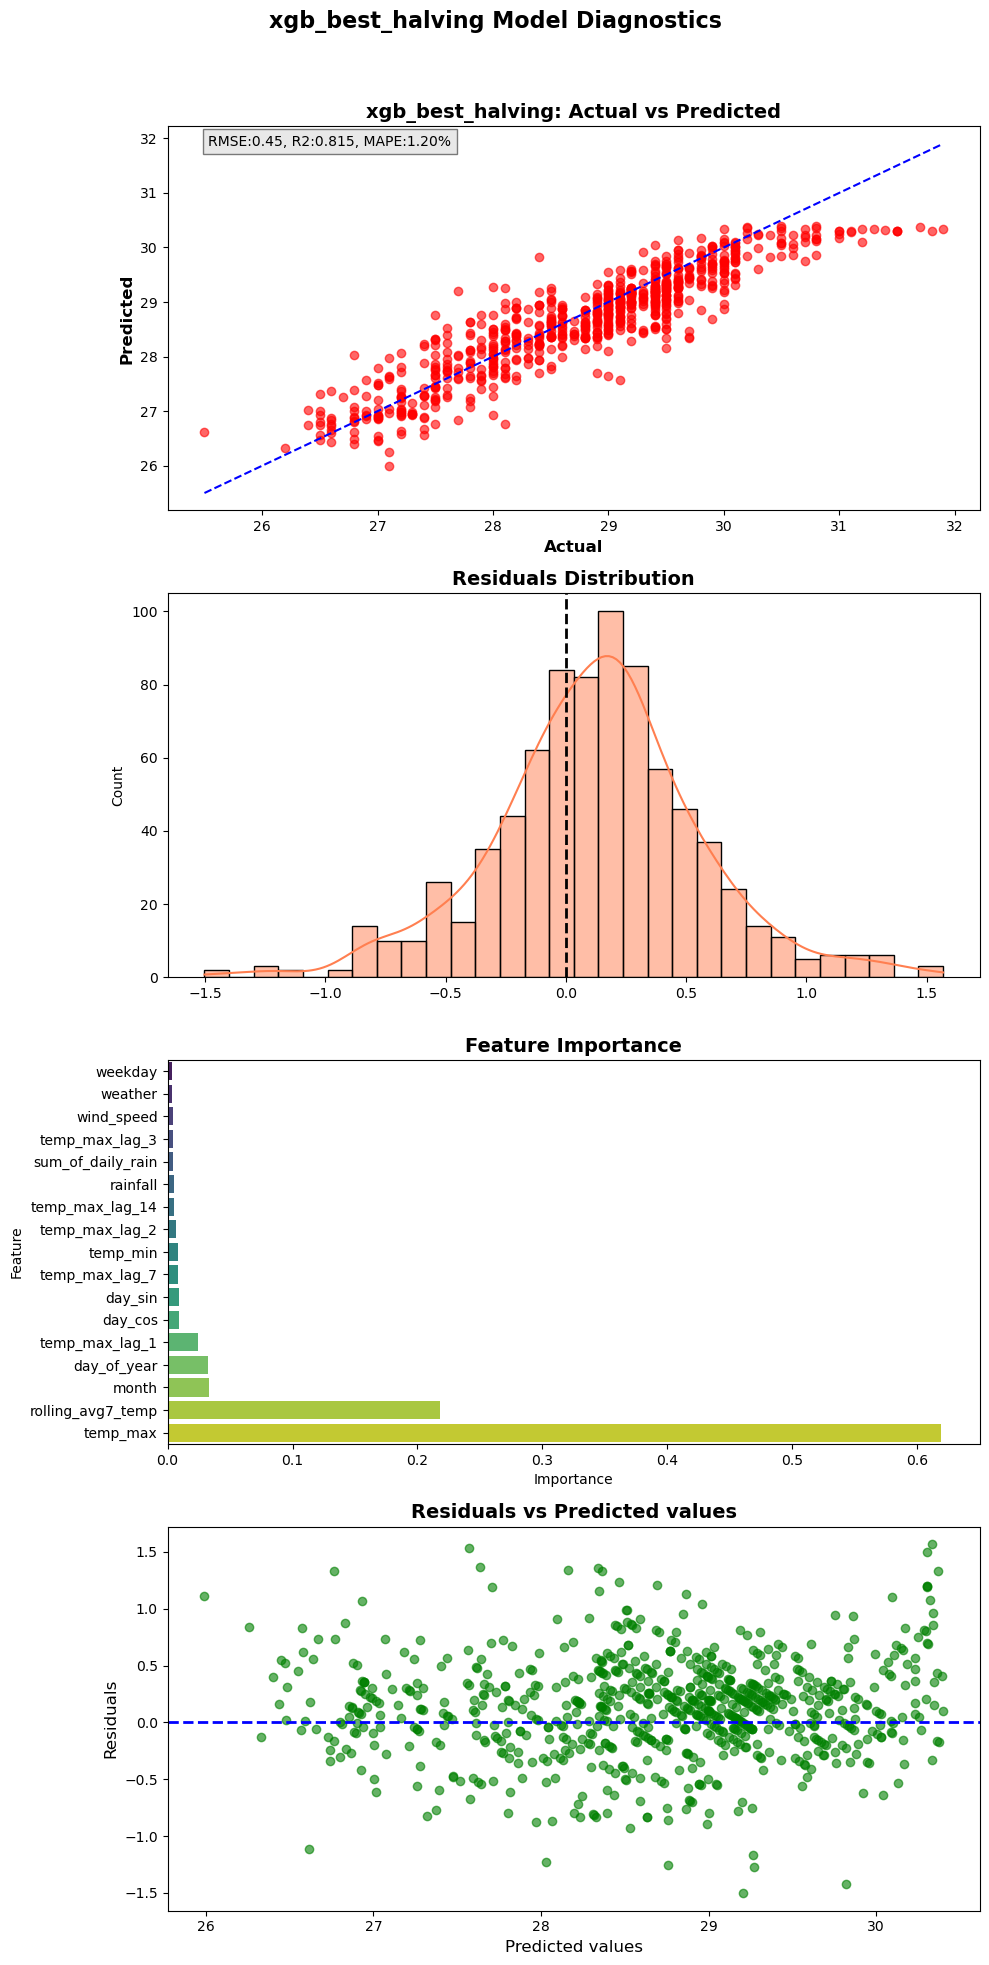

[SUCCESS] Visualization completed for xgb_best_halving
Model: xgb_best_halving, RMSE: 0.452, R²: 0.815, MAPE: 1.20%


In [23]:
results = utils.evaluate_model(x_test, y_test, name="xgb_best_halving")
print(f"Model: {results['model']}, RMSE: {results['rmse']:.3f}, R²: {results['r2']:.3f}, MAPE: {results['mape']:.2f}%")

### BASELINE and TUNED MODEL COMPARISON

comparing the metrics, we can see that the inital assumption for the baseline is strong as we got close values after hyperparameter tuning. The performance is identital to my baseline now.

## MODEL FORECAST

In [46]:
xgb_forecast = pd.DataFrame(utils.forecast_next_3_days('xgb_best_halving', x_test))
xgb_forecast['Type']= 'Forecast'
print(xgb_forecast)

Last Date:  2025-11-14 00:22:39.414087
Next Day:  2025-11-15 00:22:39.414087
Next Day:  2025-11-16 00:22:39.414087
Next Day:  2025-11-17 00:22:39.414087
         date  predicted_temp      Type
0  2025-11-15       29.610001  Forecast
1  2025-11-16       29.650000  Forecast
2  2025-11-17       29.670000  Forecast


## OPTIMIZED FORECAST
as in RandomForestRegressor

In [25]:
def optimized_forecast(model_name, data_df, n_days=3):
    predictions_list=[]
    data = data_df.copy()
    model = utils.load_model(model_name)
    if 'date' in data.columns:
        last_date = pd.to_datetime(data["date"].iloc[-1])
    else:
        last_date = pd.Timestamp.today()
    print(f"Forecasting with model: {model_name}")
    print(f"Last Date: {last_date.strftime('%Y-%m-%d')}")
    for i in range(n_days):
        x_ip = data.tail(1).drop(columns='date', errors='ignore')
        #with the last date from data, we are predicting the next days' temp
        next_pred = model.predict(x_ip)[0]
        next_day = last_date + pd.Timedelta(days=i+1)
        #store the date and temp predicted
        predictions_list.append({
            "date": next_day.strftime("%Y-%m-%d"),
            "predicted_temp": round(next_pred,2)
        })
        #preparing our new addition to the data
        new_row = x_ip.copy()
        new_row["temp_max"] = next_pred
        new_row["temp_max_lag_1"] = next_pred
        new_row["temp_max_lag_2"] = new_row["temp_max_lag_1"]
        new_row["temp_max_lag_3"] = new_row["temp_max_lag_2"]
        new_row["temp_max_lag_7"] = new_row["temp_max_lag_3"]
        #note that we have dropped our lag14
        #creatingw our rolling 7 avg
        new_row["rolling_avg7_temp"]=np.mean([new_row["temp_max_lag_1"],
                                             new_row["temp_max_lag_2"],
                                             new_row["temp_max_lag_3"],
                                             new_row["temp_max_lag_7"]])
        #day based 
        new_row["day_of_year"] = (new_row["day_of_year"]+1)%365
        new_row["day_cos"]=np.cos(2*np.pi*new_row["day_of_year"]/365)
        #NEW ROW
        data = pd.concat([data, new_row], ignore_index=True)
    return pd.DataFrame(predictions_list)

In [47]:
xgb_optimied_forecast = pd.DataFrame(optimized_forecast('xgb_best_halving', x_test, n_days=3))
xgb_optimied_forecast['Type']= 'OptimizedForecast'
print(xgb_optimied_forecast)

Forecasting with model: xgb_best_halving
Last Date: 2025-11-14
         date  predicted_temp               Type
0  2025-11-15       29.610001  OptimizedForecast
1  2025-11-16       29.250000  OptimizedForecast
2  2025-11-17       28.900000  OptimizedForecast


## FORECAST RESULTS BASELINE AND OPTIMIZED

In [48]:
forecast_df = pd.concat([xgb_forecast, xgb_optimied_forecast], ignore_index=True)
pivot_xgb = forecast_df.pivot_table(index='Type', columns='date', values='predicted_temp')
print(pivot_xgb)

date               2025-11-15  2025-11-16  2025-11-17
Type                                                 
Forecast            29.610001       29.65       29.67
OptimizedForecast   29.610001       29.25       28.90
